# Visualization of the computational experiment

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from constants.constants import RESULTS_FILE, RESULTS_BACKUP_FILE

### Fetching the results file

In [9]:
column_names = [
    'NumProducts',
    'Run',
    'Approach',
    'Consider_Constraints',
    'Time',
    'OptValue',
    'C',
    'ClingoStats_Constraints',
    'ClingoStats_Complexity',
    'ClingoStats_Vars',
    'ClingoStats_Atoms',
    'ClingoStats_Bodies',
    'ClingoStats_Rules',
    'ClingoStats_Choices',
    'ClingoStats_Conflicts',
    'ClingoStats_Restarts',
    'ClingoStats_Models',
    'Variables',
    'Constraints',
    'Order',
    'Timeout'
]

In [10]:
df = pd.read_csv(RESULTS_FILE, names=column_names)
df = df.sort_values(by=['NumProducts', 'Run', 'Approach', 'Consider_Constraints'])
df[['NumProducts', 'Run', 'Approach', 'Consider_Constraints', 'Time', 'OptValue', 'C', 'Timeout']]

,NumProducts,Run,Approach,Consider_Constraints,Time,OptValue,C,Timeout
0,6,0,lp_advanced,0,0.105975,480,480,False
155,6,0,lp_advanced,1,0.057111,480,480,False
325,6,0,lp_advanced,2,0.059961,480,480,False
490,6,0,lp_advanced,3,0.055304,480,480,False
647,6,0,lp_advanced,4,0.605193,480,480,False
...,...,...,...,...,...,...,...,...
316,47,3,lp_advanced,1,317.841664,2955,2955,False
323,48,0,lp_advanced,1,600.597392,-1,0,True
320,48,1,lp_advanced,1,600.480654,-1,0,True
322,48,2,lp_advanced,1,600.622262,-1,0,True


### Get Approaches, Runs, NumProducts and Consider_Constraints_Options

In [11]:
approaches = df['Approach'].drop_duplicates().to_list()
approaches

['lp_advanced']

In [12]:
runs = df['Run'].drop_duplicates().to_list()
runs

[0, 1, 2, 3]

In [13]:
numProducts = df['NumProducts'].drop_duplicates().to_list()
numProducts

[6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48]

In [15]:
consider_constraints_options = df['Consider_Constraints'].drop_duplicates().to_list()
consider_constraints_options

[0, 1, 2, 3, 4]

### Check data sanity

In [16]:
for numProduct in numProducts:
    for run in runs:
        for consider_constraints in consider_constraints_options:
            df_temp_numProduct = df[df['NumProducts'] == numProduct]
            df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
            df_temp_constraints = df_temp_run[df_temp_run['Consider_Constraints'] == consider_constraints]
            df_temp_constraints_woT = df_temp_constraints[df_temp_constraints['Timeout'] == False]
            if len(df_temp_constraints_woT['C'].drop_duplicates().to_list()) > 1:
                print('ERROR')
                print(f'numProduct: {numProduct} run: {run} consider_constraints: {consider_constraints}')
                print(df_temp_constraints_woT[['Approach', 'C']])
                print()

In [17]:
for numProduct in numProducts:
    for run in runs:
        for consider_constraints in consider_constraints_options:
            df_temp_numProduct = df[df['NumProducts'] == numProduct]
            df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
            df_temp_constraints = df_temp_run[df_temp_run['Consider_Constraints'] == consider_constraints]
            df_temp_constraints_woT = df_temp_constraints[df_temp_constraints['Timeout'] == False]
            if len(df_temp_constraints_woT['Order'].drop_duplicates().to_list()) > 1:
                print('ERROR')
                print(f'numProduct: {numProduct} run: {run} consider_constraints: {consider_constraints}')
                print(df_temp_constraints_woT[['Approach', 'Order']])
                print()

### Preprocessing the data for plotting

In [18]:
metrics = {
    'Time': 'Computation time (in sec)',
    'ClingoStats_Constraints': 'Number of constraints (clingo)',
    'ClingoStats_Complexity': 'Degree of complexity (clingo)',
    'ClingoStats_Vars': 'Number of variables (clingo)',
    'ClingoStats_Atoms': 'Number of atoms (clingo)',
    'ClingoStats_Bodies': 'Number of bodies (clingo)',
    'ClingoStats_Rules': 'Number of rules (clingo)',
    'ClingoStats_Choices': 'Number of choices (clingo)',
    'ClingoStats_Conflicts': 'Number of conflicts (clingo)',
    'ClingoStats_Restarts': 'Number of restarts (clingo)',
    'ClingoStats_Models': 'Number of models (clingo)',
    'Variables': 'Number of variables (docplex)',
    'Constraints': 'Number of constraints (docplex)'
}

In [25]:
data = {}
for approach in approaches:
    data[approach] = {}
    df_approach = df[df['Approach'] == approach]

    for consider_constraints in consider_constraints_options:
        data[approach][consider_constraints] = {}
        df_constraints = df_approach[df_approach['Consider_Constraints'] == consider_constraints]
        
        for metric in metrics:
            data[approach][consider_constraints][metric] = {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []}
        
            for numProduct in numProducts:
                df_numProduct = df_constraints[df_constraints['NumProducts'] == numProduct]
                if metric != 'Time':
                    df_numProduct = df_numProduct[df_numProduct['Timeout'] == False]
                
                if not df_numProduct.empty:
                    values = df_numProduct[metric].to_list()
                    lb = min(values)
                    ub = max(values)
                    mean = float(sum(values)) / len(values)
                    if not pd.isna(mean):
                        data[approach][consider_constraints][metric]['lbs'].append(lb)
                        data[approach][consider_constraints][metric]['ubs'].append(ub)
                        data[approach][consider_constraints][metric]['means'].append(mean)
                        data[approach][consider_constraints][metric]['numProducts'].append(numProduct)

## Creating plots

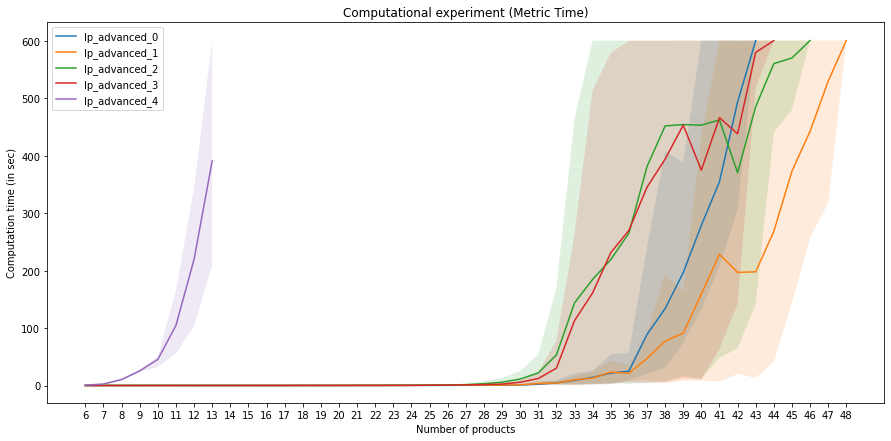

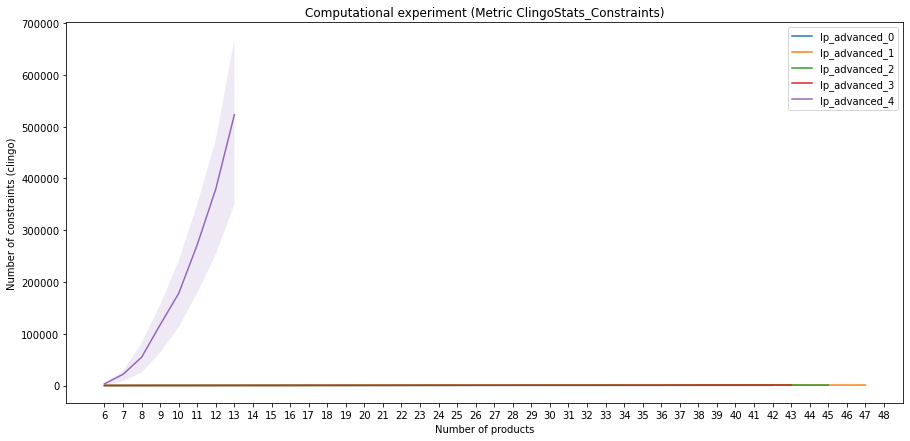

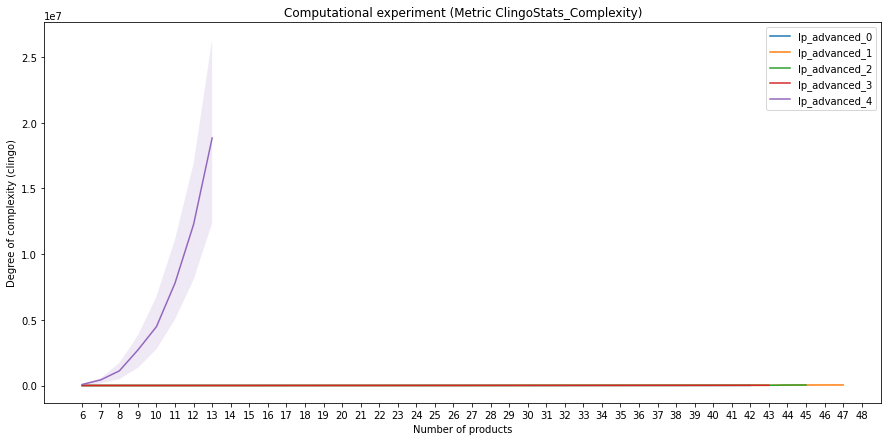

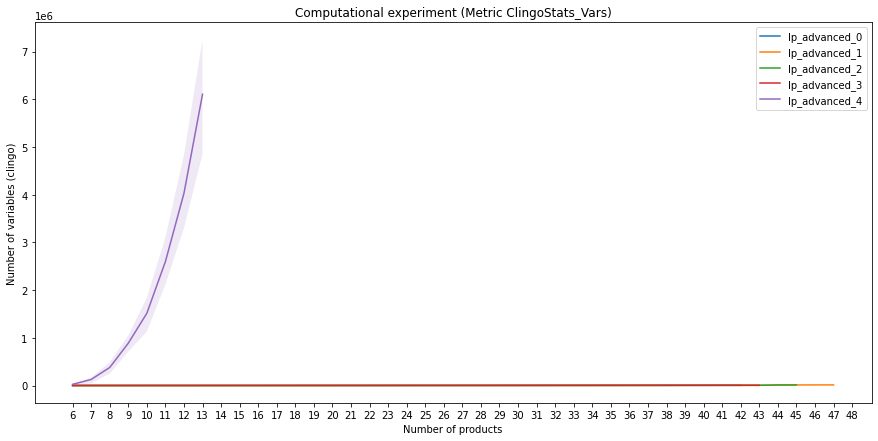

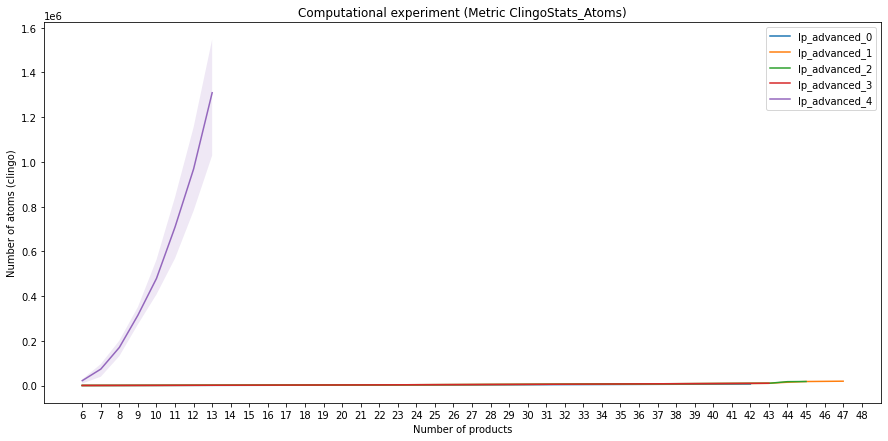

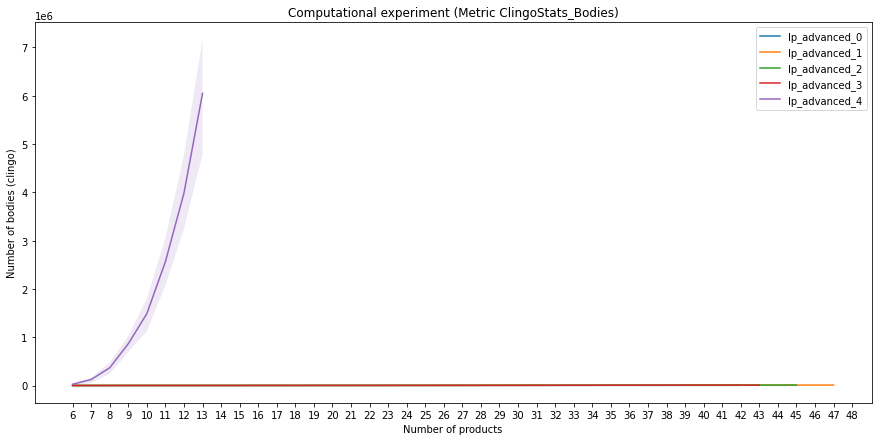

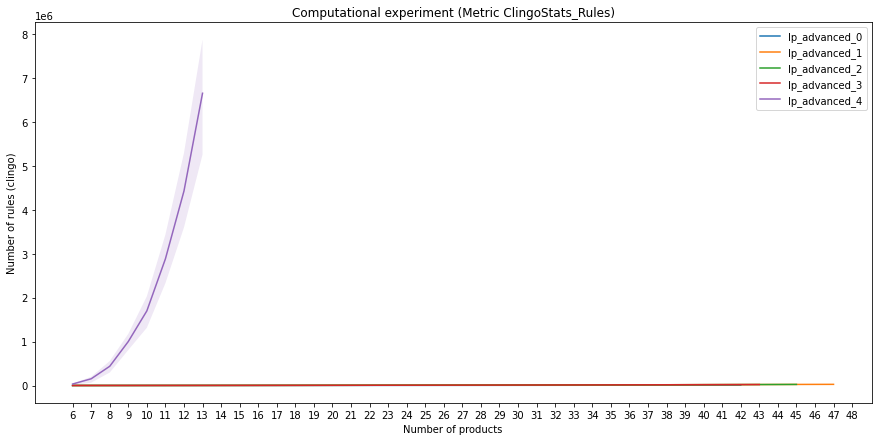

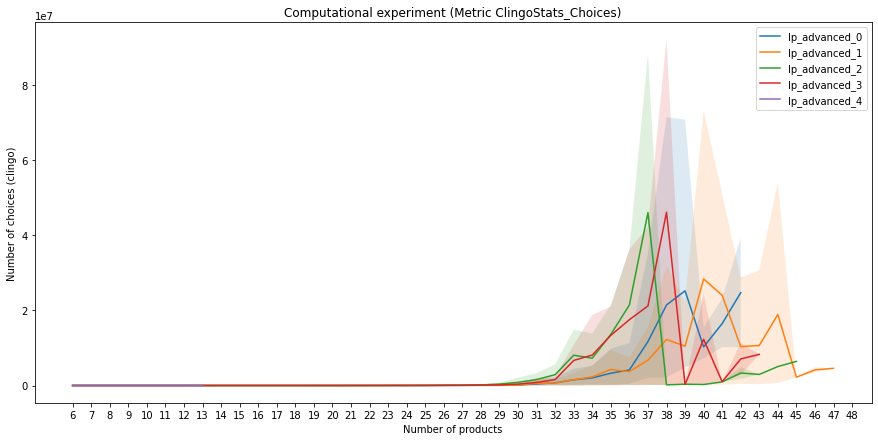

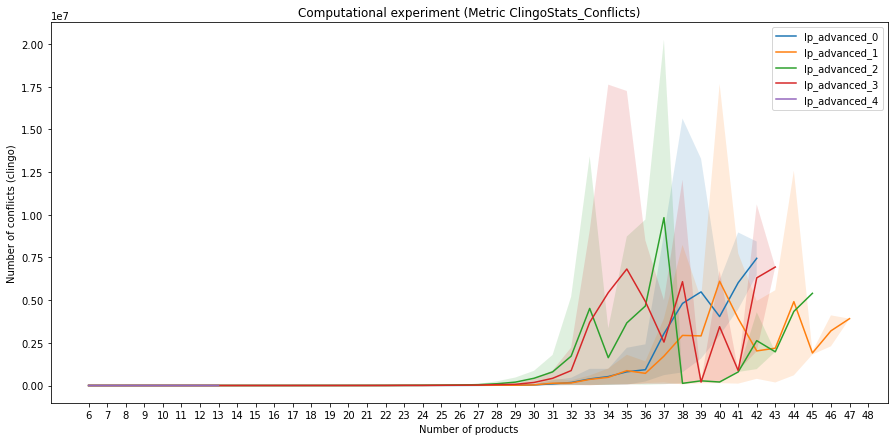

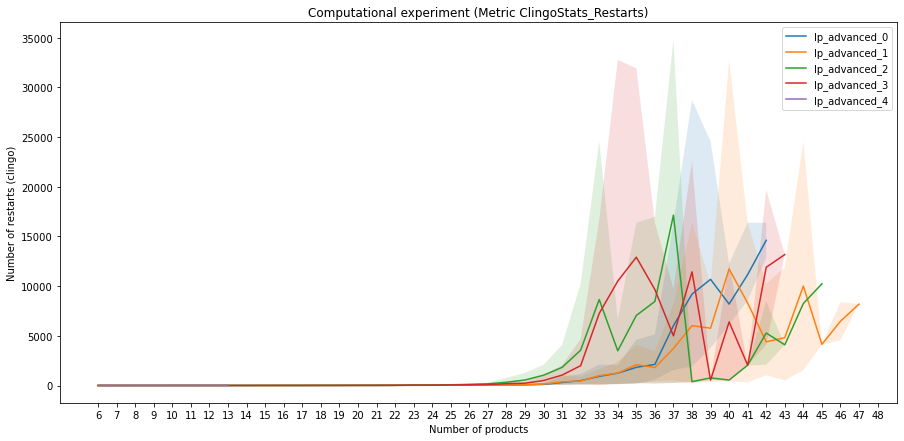

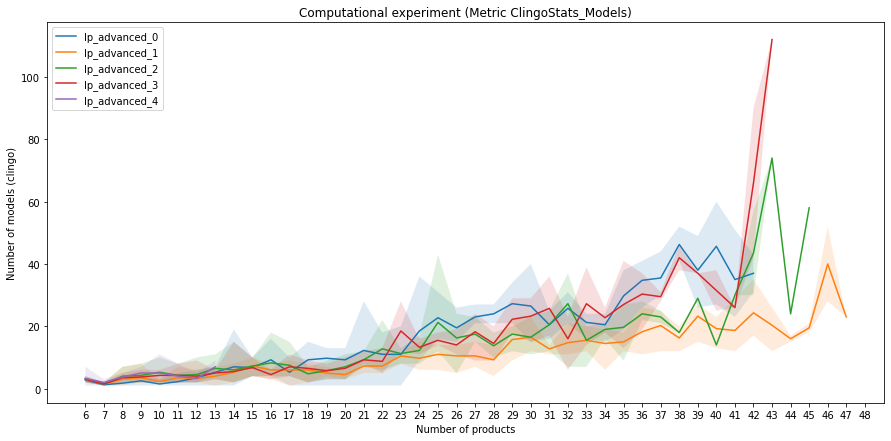

No handles with labels found to put in legend.


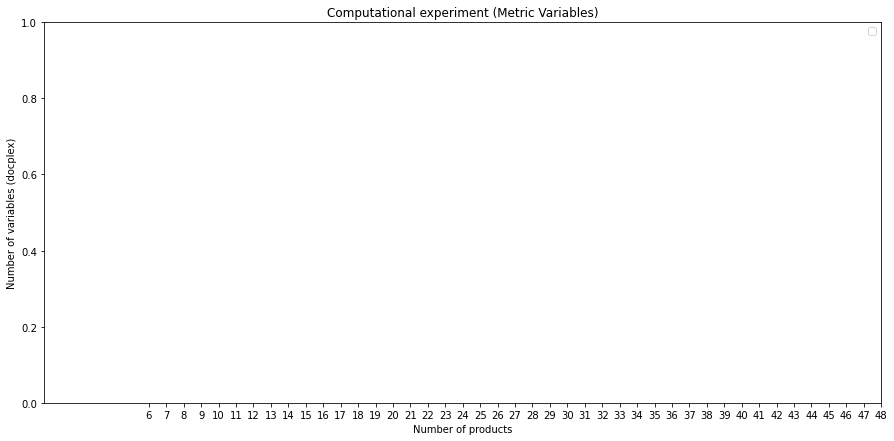

No handles with labels found to put in legend.


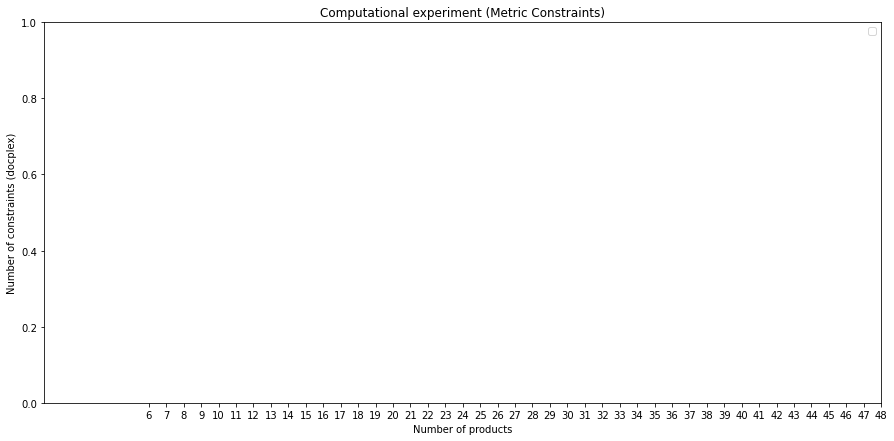

In [27]:
for metric, ylabel in metrics.items():
    plt.figure(figsize=(15, 7))
    plt.title(f'Computational experiment (Metric {metric})')
    plt.xticks(numProducts)
    plt.xlabel('Number of products')
    plt.ylabel(ylabel)

    for approach in approaches:
        for consider_constraints in consider_constraints_options:
            if len(data[approach][consider_constraints][metric]['numProducts']) > 0:
                plt.plot(
                    data[approach][consider_constraints][metric]['numProducts'],
                    data[approach][consider_constraints][metric]['means'],
                    label=f'{approach}_{consider_constraints}')
                plt.fill_between(
                    data[approach][consider_constraints][metric]['numProducts'],
                    data[approach][consider_constraints][metric]['lbs'],
                    data[approach][consider_constraints][metric]['ubs'],
                    alpha=0.15)

    plt.legend()
    plt.show()